In [1]:
!pip install --quiet git+https://github.com/EgorDudyrev/paspailleur.git
import caspailleur as csp
from paspailleur import pattern_structures as PS

In [2]:
from importlib import reload

In [3]:
from script import clustering as clib, visual_lib as vlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from functools import reduce
from bitarray import frozenbitarray

# Test examples on Circles data

In [5]:
from sklearn import datasets

n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
X, y = noisy_circles

In [6]:
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
X, y = blobs

In [7]:
linscale_x = np.linspace(X[:,0].min(), X[:,0].max(), 11)
linscale_y = np.linspace(X[:,1].min(), X[:,1].max(), 11)
ps = PS.CartesianPS([PS.IntervalPS(values=linscale_x), PS.IntervalPS(values=linscale_y)])

In [8]:
min_support = 0.01
max_support = 0.8
min_delta_stability = 0.01

In [9]:
data = list(ps.preprocess_data(X))
attributes, attr_extents = zip(*ps.iter_attributes(data, min_support=min_support))
print(len(attributes))

37


In [10]:
%%time
stable_extents = csp.mine_equivalence_classes.list_stable_extents_via_gsofia(
    attr_extents,
    n_objects=len(data), min_delta_stability=min_delta_stability, min_supp=min_support,
    use_tqdm=True, n_attributes=len(attributes)
)
stable_extents = sorted(stable_extents, key=lambda ext: ext.count(), reverse=True)
print(f"n extents", len(stable_extents))

  0%|          | 0/37 [00:00<?, ?it/s]

n extents 697
CPU times: user 18.7 ms, sys: 7.97 ms, total: 26.6 ms
Wall time: 26.1 ms


In [11]:
from bitarray.util import count_and, count_or

jaccard_thold = 0.9
min_added_coverage = 75
sparse_extents = []
for i, extent in enumerate(stable_extents):
    if extent.count() < min_added_coverage:
        continue
        
    not_like_others = all(count_and(extent, other)/count_or(extent, other) <= jaccard_thold
                          for other in sparse_extents)
    if not_like_others:
        sparse_extents.append(extent)
print(len(stable_extents), len(sparse_extents))

697 221


In [12]:
%%time
clusterings = list(clib.mine_clusterings(sparse_extents, min_support=450, max_length=5,
                                         min_added_coverage=min_added_coverage))
print(len(clusterings))

7453
CPU times: user 2.4 s, sys: 15.8 ms, total: 2.41 s
Wall time: 2.41 s


In [13]:
print(max(map(len, clusterings)))

5


In [14]:
concepts_dict = clib.mine_clusters_info(sparse_extents, attr_extents, ps, data, 0, 1)

In [15]:
weight_params = dict(
    overlap_weight=0.2,
    n_concepts_weight=0.1,
    imbalance_weight=0.1,
    stability_weight=0.2,
    complexity_weight=0.1,
    n_concepts_max=5,
)
clusterings_dict = {
    idxs: clib.clustering_reward2(idxs, concepts_info=concepts_dict, **weight_params)[1]
    for idxs in clusterings
}
clusterings_df = pd.DataFrame(clusterings_dict).T
clusterings_df.index = clusterings

In [16]:
if 'reward' in clusterings_df.columns:
    clusterings_df = clusterings_df.drop(columns='reward')

signs = np.array([1 if f in {'coverage', 'stability'} else -1 for f in clusterings_df])
weights = np.array([1 if f == 'coverage' else weight_params[f"{f}_weight"] for f in clusterings_df])

clusterings_df['reward'] = (clusterings_df*weights*signs).sum(1)

In [17]:
clusterings_df = clusterings_df.sort_values('reward', ascending=False)

In [18]:
clusterings_df.head()

,coverage,overlap,n_concepts,imbalance,stability,complexity,reward
"(0,)",0.996,0.000000,0.2,0.000000,0.115385,0.50,0.949077
"(21, 75)",0.986,0.000000,0.4,0.166127,0.125000,0.75,0.879387
"(7, 119)",0.966,0.066265,0.4,0.326575,0.346154,0.75,0.874320
"(21, 35)",0.952,0.174699,0.4,0.066735,0.394231,0.75,0.874233
"(40, 42)",0.984,0.000000,0.4,0.002840,0.115385,1.00,0.866793


In [19]:
best_clustering = clusterings_df.index[2]
#best_clustering = clusterings_df.sort_values('overlap').index[0]
concepts_df = pd.DataFrame(concepts_dict)

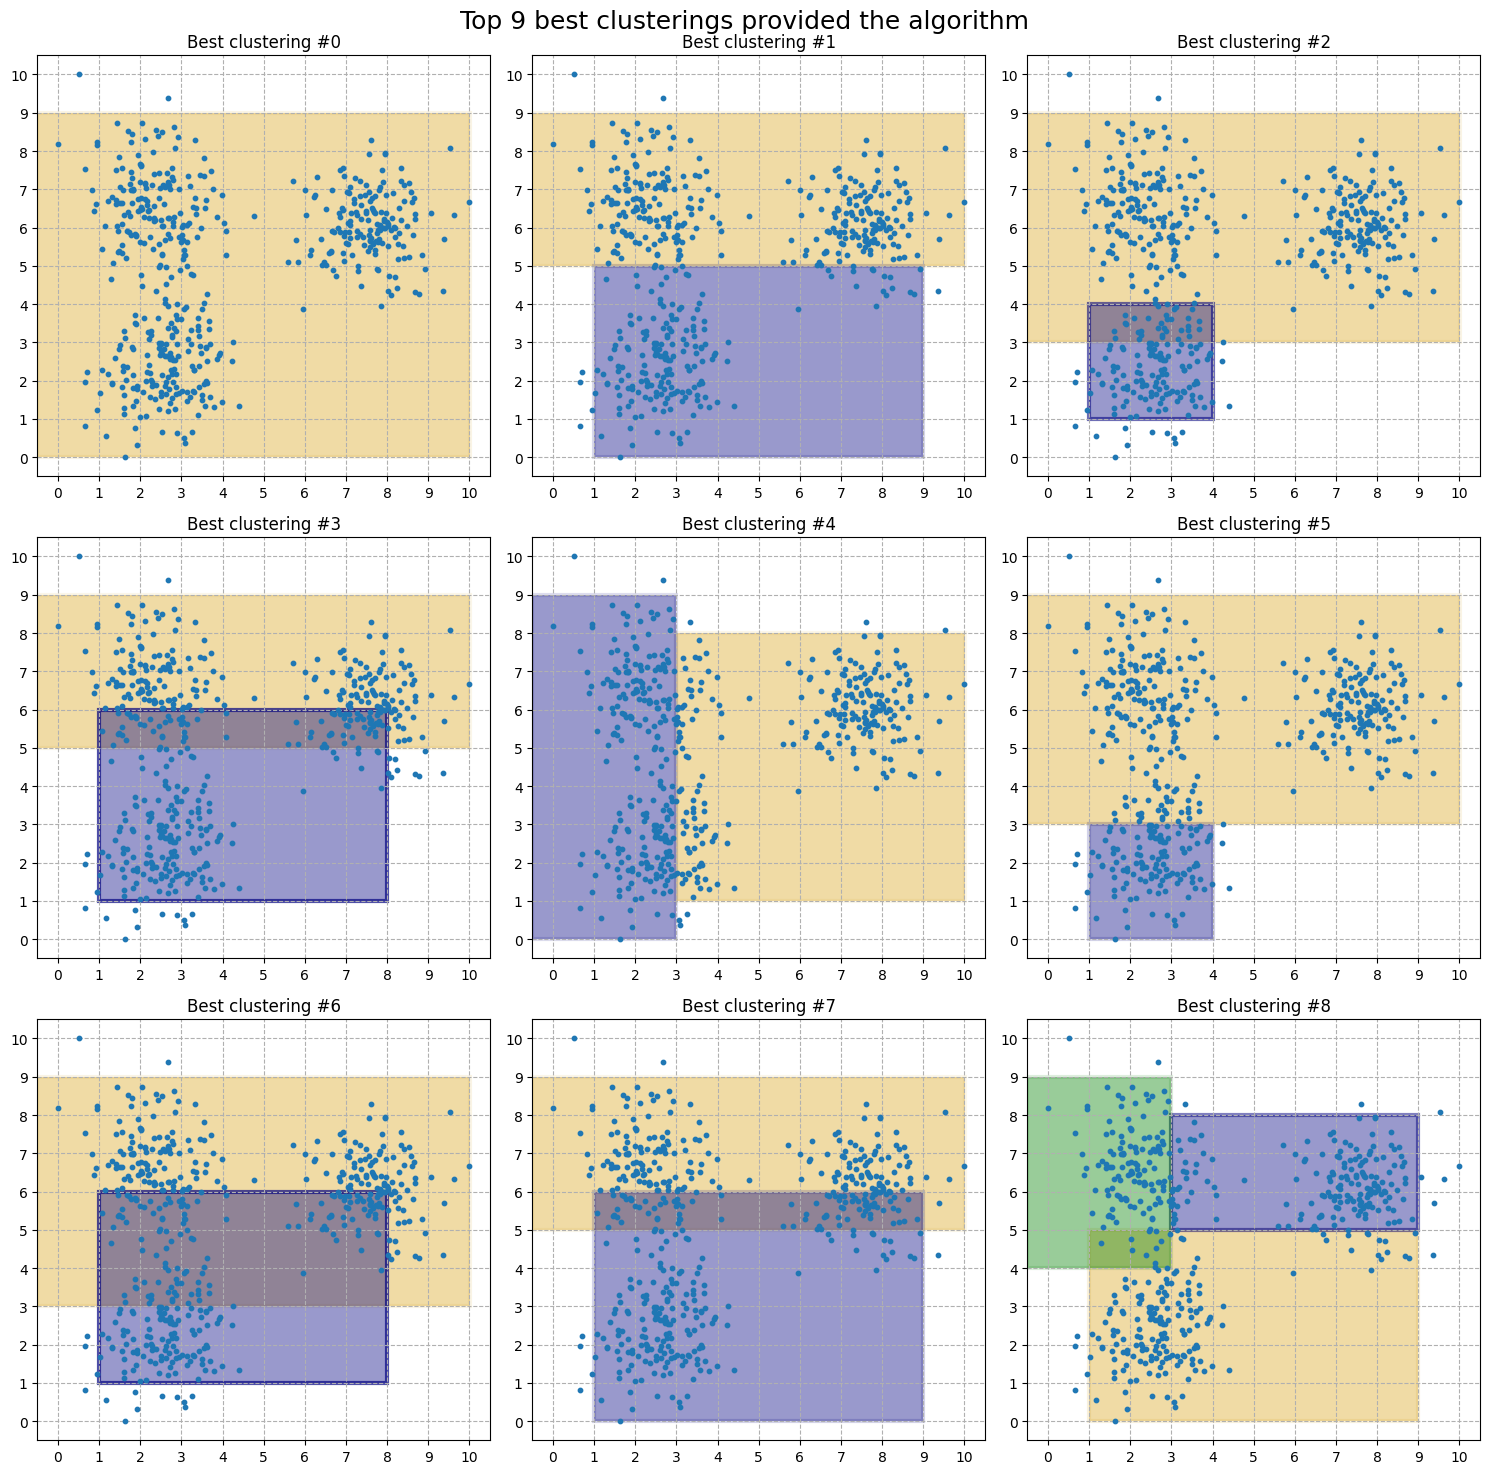

In [ ]:
best_clustering = clusterings_df.index[9]

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, (ax, best_clustering) in enumerate(zip(axs.flatten(), clusterings_df.index)):
    vlib.init_axis(ax, f"Best clustering #{i}", 
                   linscale_x, linscale_y, range(len(linscale_x)), range(len(linscale_y)), 
                   grid_params=dict(zorder=0, linestyle='--'))
    
    ax.scatter(X[:,0], X[:,1], zorder=2, s=10)
    vlib.draw_clustering(ax, best_clustering, concepts_df)

fig.suptitle('Top 9 best clusterings provided the algorithm', size=18)
fig.tight_layout()
fig.subplots_adjust()
# ax.legend(loc='lower right')
#fig.savefig('../figures/pipe_step4_circlesdata.pdf')
plt.show()

In [21]:
clusterings4_df = clusterings_df[clusterings_df['n_concepts']==5/5]
print(len(clusterings4_df))

666


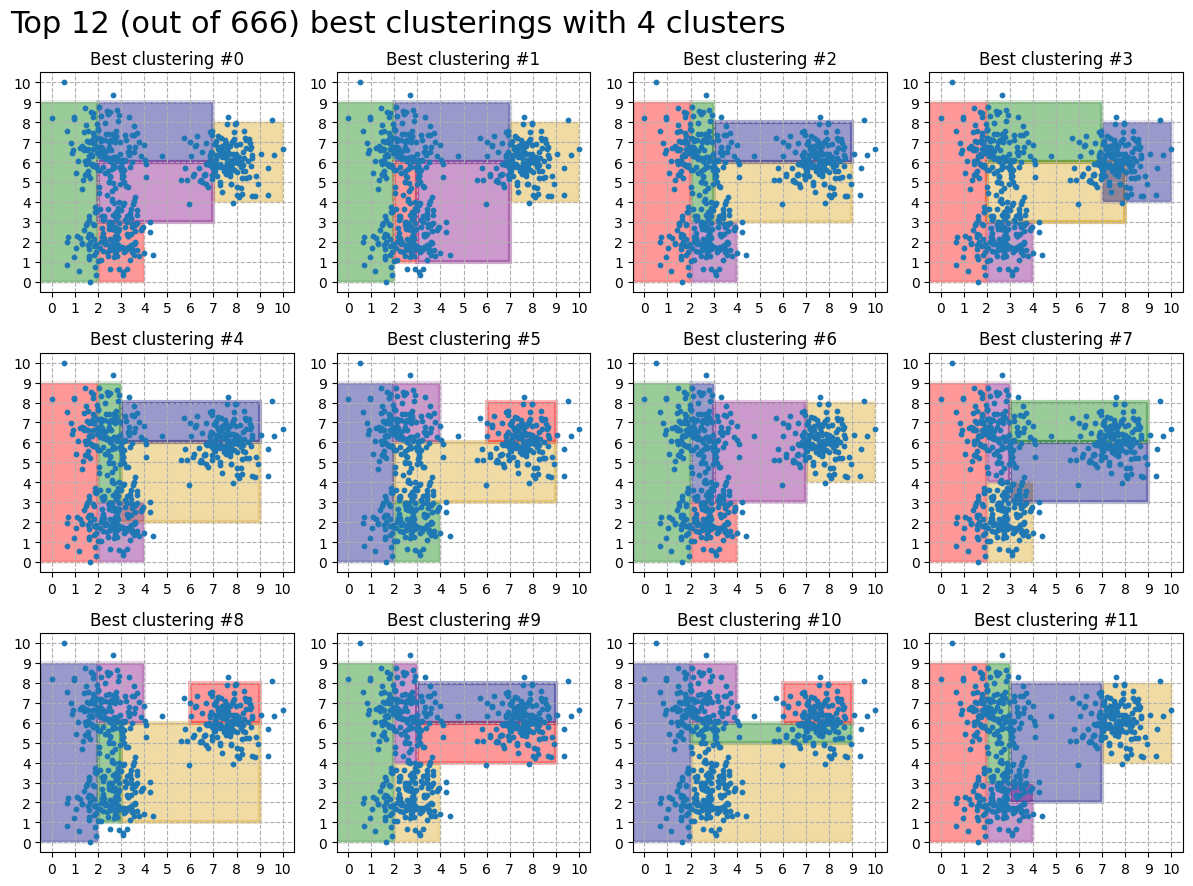

In [22]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9))

for i, (ax, best_clustering) in enumerate(zip(axs.flatten(), clusterings4_df.index)):
    vlib.init_axis(ax, f"Best clustering #{i}", 
                   linscale_x, linscale_y, range(len(linscale_x)), range(len(linscale_y)), 
                   grid_params=dict(zorder=0, linestyle='--'))
    
    ax.scatter(X[:,0], X[:,1], zorder=2, s=10)
    vlib.draw_clustering(ax, best_clustering, concepts_df)

fig.suptitle(f'Top {len(axs.flatten())} (out of {len(clusterings4_df)}) best clusterings with 4 clusters',
             size=22, ha='left', x=0.01)
fig.tight_layout()
fig.subplots_adjust()
# ax.legend(loc='lower right')
#fig.savefig('../figures/best_clusters4_circlesdata.pdf')
plt.show()